# Stock Price Prediction

In this notebook, we demonstrate a reference use case where we use historical stock price data to predict the future price. The dataset we use is the daily stock price of S&P500 stocks during 2013-2018 ([data source](https://www.kaggle.com/camnugent/sandp500/)). We demostrate how to do univariate forecasting using the past 966 days of MMM price to predict the future 244 daily price.

Reference: https://github.com/jwkanggist/tf-keras-stock-pred



## Get Data

We will use the close prices of MMM stock for our experiment. We will 
  1. download raw dataset and load into dataframe. 
  2. Extract the close prices of MMM stock from the dataframe into a numpy array

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
# S&P 500
FILE_NAME    = 'all_stocks_5yr.csv'
SOURCE_URL   = 'https://github.com/CNuge/kaggle-code/raw/master/stock_data/' 

filepath = './data/'+ FILE_NAME
filepath = os.path.join('data', FILE_NAME)
print(filepath)

data/all_stocks_5yr.csv


In [3]:
# download data
!if ! [ -d "data" ]; then mkdir data; cd data; wget https://github.com/CNuge/kaggle-code/raw/master/stock_data/individual_stocks_5yr.zip; wget https://raw.githubusercontent.com/CNuge/kaggle-code/master/stock_data/merge.sh; chmod +x merge.sh; unzip individual_stocks_5yr.zip; ./merge.sh; fi


In [4]:
# read data
data = pd.read_csv(filepath)
print(data[:10])

target_rows = data[data['Name']=='MMM']
print(target_rows[:10])

         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
5  2013-02-15  13.93  14.61  13.93  14.50  15628000  AAL
6  2013-02-19  14.33  14.56  14.08  14.26  11354400  AAL
7  2013-02-20  14.17  14.26  13.15  13.33  14725200  AAL
8  2013-02-21  13.62  13.95  12.90  13.37  11922100  AAL
9  2013-02-22  13.57  13.60  13.21  13.57   6071400  AAL
              date    open      high       low   close   volume Name
381385  2013-02-08  102.34  103.3300  102.0400  102.66  1937721  MMM
381386  2013-02-11  102.39  102.8800  102.0401  102.62  1715444  MMM
381387  2013-02-12  102.66  103.5900  102.6300  103.46  1927930  MMM
381388  2013-02-13  103.03  103.3950  102.5800  102.86  1699804  MMM
381389  2013-02-14  102.43  

In [5]:
# extract close value
close_val = target_rows[['close']].values
print(close_val[:10])

[[102.66]
 [102.62]
 [103.46]
 [102.86]
 [102.78]
 [103.23]
 [104.18]
 [103.15]
 [102.72]
 [103.54]]


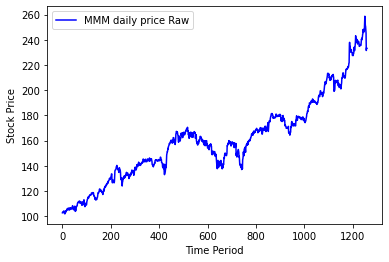

In [6]:
# Visualize data

import matplotlib.pyplot as plt
plt.plot(close_val, color='blue', label='MMM daily price Raw')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

## Data Pre-processing
Now we need to do data cleaning and preprocessing on the raw data. Note that this part could vary for different dataset.

For the stock price data we're using, the processing contains 2 parts:

1.   Data normalization such that the normalized stock prices fall in the range of 0 to 1
2.   Extract time series of given window_size



In [7]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(data):
    """
    Use sklearn.preprocessing.MinMaxScaler() to normalize data (min = 0, max = 1)
        1. X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
        2. X_scaled = X_std * (max - min) + min
    """
    data_normalized = MinMaxScaler().fit_transform(data)
    return data_normalized

close_val_norm = normalize_data(close_val)

In [8]:
def process_data(data, window_size):
    """
    Extract time series of given window_size and construct the dataset
    """
    X, y = [], []
    for i in range(len(data)-window_size-1):
        X.append(data[i:(i+window_size)])
        y.append(data[(i+window_size)])
    return np.array(X), np.array(y)

window_size = 50
X, y = process_data(close_val_norm, window_size)

In [9]:
# train/test split
X_train, X_test = X[:int(X.shape[0]*0.80)], X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)], y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])

966
242


## Time series forecasting

We use LSTMForecaster for forecasting.

In [10]:
from zoo.zouwu.model.forecast.lstm_forecaster import LSTMForecaster

First we initiate a LSTMForecaster.


*   `feature_dim` should match the dimension of the input data, so we just use the last dimension of train input data shape
*   `target_dim` equals the dimension of the output data, here we set `target_dim=1` for univariate forecasting.



In [11]:
# Hyperparameters
feature_dim = X_train.shape[-1]
target_dim = 1
hidden_dim = 10
learning_rate = 0.01
batch_size = 16
epochs = 50

In [12]:
# build model
lstm_config = {"lstm_units": [hidden_dim] * 1, "lr": learning_rate}
forecaster = LSTMForecaster(target_dim=target_dim, feature_dim=feature_dim, **lstm_config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Then we use fit to train the model. Wait sometime for it to finish.

In [13]:
%%time
forecaster.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, distributed=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 966 samples
Epoch 1/50
966/966 [==============================] - 3s 3ms/sample - loss: 0.0148 - mean_squared_error: 0.0148
Epoch 2/50
966/966 [==============================] - 2s 3ms/sample - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 3/50
966/966 [==============================] - 2s 3ms/sample - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 4/50
966/966 [==============================] - 2s 3ms/sample - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 5/50
966/966 [==============================] - 2s 3ms/sample - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 6/50
966/966 [==============================] - 2s 3ms/sample - loss: 7.8184e-04 - mean_squared_error: 7.8184e-04
Epoch 7/50
966/966 [==============================] - 2s 3ms/sample - loss: 7.7546e-04 - mean_squared_error: 7.7546e-04
Epoch 8/50
966/966 [==============================] - 2s 3ms/sample - loss: 7.5335e-0


After training is finished. You can use the forecaster to do prediction and evaluation.

In [14]:
# make prediction
y_pred = forecaster.predict(X_test)

Calculate the mean square error.

In [15]:
# evaluate with mean_squared_error
from sklearn.metrics import mean_squared_error
print("mean_squared error is", mean_squared_error(y_test, y_pred))

mean_squared error is 0.000557959258876489


Visualize the prediction.

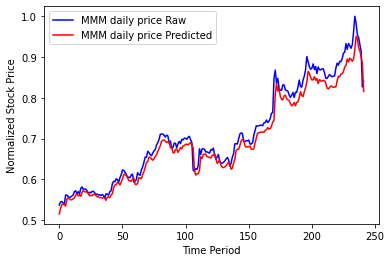

In [16]:
# Plot predictions
plt.plot(y_test, color='blue', label="MMM daily price Raw")
plt.plot(y_pred, color='red', label="MMM daily price Predicted")
plt.xlabel("Time Period")
plt.ylabel("Normalized Stock Price")
plt.legend()
plt.show()